In [124]:
import os
import torch
import pandas as pd
#from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import RandomRotation
from torchvision.transforms import v2
from PIL import Image
import cv2
from tqdm import tqdm

import time

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import lightning as L
import pytorch_lightning as pl
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.functional import accuracy
import timm
import json

from torchmetrics.classification import MulticlassAccuracy, MulticlassRecall, MulticlassPrecision, MulticlassF1Score, MulticlassSpecificity
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

from batchgenerators.transforms.abstract_transforms import Compose
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, \
    ContrastAugmentationTransform, BrightnessTransform, GammaTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform
from batchgenerators.transforms.resample_transforms import SimulateLowResolutionTransform
from batchgenerators.transforms.spatial_transforms import SpatialTransform, MirrorTransform
from batchgenerators.transforms.utility_transforms import NumpyToTensor

In [203]:
BATCH_SIZE = 24
#TEST_TO_TRAIN_RATIO = 0.2
NUM_TEST_SAMPLES = 20000
NUM_VALID_SAMPLES = 20000
LEARNING_RATE = 0.001
NUM_EPOCHS = 1
torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [133]:
df = pd.read_csv("vposition_dataset.csv")
df.rename(columns={"Unnamed: 0":"GlobalId"}, inplace=True)

In [134]:
len(df)

223397

In [135]:
df.head()

,GlobalId,Path,PatientID,Laterality,AP,PA
0,0,CheXpert-v1.0-small/train/patient00001/study1/...,patient00001,0,1,0
1,1,CheXpert-v1.0-small/train/patient00002/study2/...,patient00002,0,1,0
2,2,CheXpert-v1.0-small/train/patient00002/study1/...,patient00002,0,1,0
3,3,CheXpert-v1.0-small/train/patient00002/study1/...,patient00002,1,0,0
4,4,CheXpert-v1.0-small/train/patient00003/study1/...,patient00003,0,1,0


In [136]:
def omit_lateral(df):
    omitted_df = df.loc[df["Laterality"]==0]
    omitted_df = omitted_df.drop(columns=["Laterality"])
    return omitted_df

In [137]:
df = omit_lateral(df)

In [155]:
def split_df_valid_test(df, under_sample=False, limit_class_size=0, valid_size=NUM_VALID_SAMPLES, test_size=NUM_TEST_SAMPLES):
    df = df.sample(frac=1, random_state=42)
    valid_end_ind = valid_size
    valid_df = df[:valid_end_ind].copy(deep=True)
    
    test_end_ind = valid_end_ind + test_size
    test_df = df[valid_end_ind:test_end_ind].copy(deep=True)

    train_df = df[test_end_ind:].copy(deep=True)

    if under_sample == True:
        res = train_df.groupby("AP").apply(lambda x: x.sample(n=min(sum(train_df["AP"]==1),sum(train_df["PA"]==1))))
        res = res.sample(frac=1)
        res.reset_index(drop=True, inplace=True)
        train_df = res

    if limit_class_size != 0:
        res = train_df.groupby("AP").apply(lambda x: x.sample(n=min(len(x), limit_class_size)))
        res = res.sample(frac=1)
        res.reset_index(drop=True, inplace=True)
        train_df = res

    train_df.reset_index(drop=True, inplace=True)
    valid_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)

    return train_df, valid_df, test_df

In [167]:
#train, valid, test "under" are where the bigger class was undersampled
#train, valid, test "limit" are where there was a limit to max num. of instances of the class
#train, valid, test "max" are where no additional constraints were used and the maximum number of data that can be used in the df was used

In [156]:
train_df_under, valid_df_under, test_df_under = split_df_valid_test(df, valid_size=NUM_VALID_SAMPLES, test_size=NUM_TEST_SAMPLES,under_sample=True)
train_df_limit, valid_df_limit, test_df_limit = split_df_valid_test(df, valid_size=5000, test_size=NUM_TEST_SAMPLES, limit_class_size=10000)
train_df_max, valid_df_max, test_df_max = split_df_valid_test(df, valid_size=NUM_VALID_SAMPLES, test_size=NUM_TEST_SAMPLES)

/tmp/ipykernel_957534/1256907439.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = train_df.groupby("AP").apply(lambda x: x.sample(n=min(sum(train_df["AP"]==1),sum(train_df["PA"]==1))))


In [165]:
sum(valid_df_max["PA"]==1)

3084

train_df_under.to_csv("appa_train_under.csv")
valid_df_under.to_csv("appa_valid_under.csv")
test_df_under.to_csv("appa_test_under.csv")

train_df_limit.to_csv("appa_train_limit.csv")
valid_df_limit.to_csv("appa_valid_limit.csv")
test_df_limit.to_csv("appa_test_limit.csv")

train_df_max.to_csv("appa_train_max.csv")
valid_df_max.to_csv("appa_valid_max.csv")
test_df_max.to_csv("appa_test_max.csv")

In [98]:
train_df_under = pd.read_csv("appa_train_under.csv")
valid_df_under = pd.read_csv("appa_valid_under.csv")
test_df_under = pd.read_csv("appa_test_under.csv")

In [146]:
train_df_limit = pd.read_csv("appa_train_limit.csv")
valid_df_limit = pd.read_csv("appa_valid_limit.csv")
test_df_limit = pd.read_csv("appa_test_limit.csv")

In [ ]:
train_df_max = pd.read_csv("appa_train_max.csv")
train_df_max = pd.read_csv("appa_train_max.csv")
train_df_max = pd.read_csv("appa_train_max.csv")

In [147]:
psd_train_df = train_df[:2000]
psd_valid_df = valid_df[:2000]
psd_test_df = test_df[:2000]

In [148]:
tr_transforms = [
    GaussianNoiseTransform( p_per_sample = 0.15, data_key = 'data', noise_variance = (0, 0.1), p_per_channel = 1, per_channel = False ),
    GaussianBlurTransform( p_per_sample = 0.2, different_sigma_per_channel = True, p_per_channel = 0.5, data_key = 'data', blur_sigma = (0.5, 1.5), different_sigma_per_axis = False, p_isotropic = 0 ),
    BrightnessMultiplicativeTransform( p_per_sample = 0.15, data_key = 'data', multiplier_range = (0.7, 1.3), per_channel = True ),
    ContrastAugmentationTransform( p_per_sample = 0.15, data_key = 'data', contrast_range = (0.65, 1.5), preserve_range = True, per_channel = True, p_per_channel = 1 ),
    SimulateLowResolutionTransform( order_upsample = 3, order_downsample = 0, channels = None, per_channel = True, p_per_channel = 0.5, p_per_sample = 0.25, data_key = 'data', zoom_range = (0.5, 1), ignore_axes = None ),
    GammaTransform( p_per_sample = 0.15, retain_stats = True, per_channel = True, data_key = 'data', gamma_range = (0.5, 1.6), invert_image = True ),
    BrightnessTransform( p_per_sample = 0.3, data_key = 'data', mu = 0, sigma = 0.2, per_channel = True, p_per_channel = 1 ),
    GammaTransform( p_per_sample = 0.3, retain_stats = True, per_channel = True, data_key = 'data', gamma_range = (0.5, 1.6), invert_image = False ),
    MirrorTransform( p_per_sample = 1, data_key = 'data', axes = (0, 1) ),
    NumpyToTensor( keys = ['data', 'target'], cast_to = 'float' )]
tr_transforms = Compose(tr_transforms)

In [168]:
class APPAClassifierDataset(Dataset):

    #Labeles are in form [Laterality, AP, PA]
    def __init__(self, csv_file, root_dir, batch_size=BATCH_SIZE, img_shape=(320,320), transform=None):

        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        self.batch_size = batch_size
        self.img_shape = img_shape
        self.num_samples = len(self.df)


    def __len__(self):
        return len(self.df)

    def get_path_from_index(self, idx):
        return self.df.iloc[idx]["Path"]
    
    def get_image_with_idx(self, idx):
        #img_path = os.path.join(self.root_dir,
        #                        self.df.iloc[idx]["Path"])

        specific_path = self.df.iloc[idx]["Path"]
        #omit_train = specific_path[:specific_path.index("train/")]+specific_path[specific_path.index("train/")+6:]
        omit_chexpert = specific_path[:specific_path.index("CheXpert-v1.0-small/")]+specific_path[specific_path.index("CheXpert-v1.0-small/")+20:]

        img_path = self.root_dir+"/"+specific_path

        image = Image.open(img_path)
        image = np.array(image, dtype=float)
        image = (image-np.min(image))/(np.max(image)-np.min(image))
        image = cv2.resize(image, self.img_shape)

        return image

    def util_getitem(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.get_image_with_idx(idx)

        #label is in form [Laterality, AP, PA]
        label = np.array([self.df.iloc[idx]["AP"],self.df.iloc[idx]["PA"]])

        image = np.array(image)
        label = np.array(label)

        sample = {'image': image, 'label': label}

        #if self.transform:
        #    sample = self.transform(sample)
        
        return sample

    def generate_train_batch(self, idx):
        # usually you would now select random instances of your data. We only have one therefore we skip this

        # Our batch layout must be (b, c, x, y). Let's fix that

        #batch_slices = self.get_batch_slices()

        start = idx * self.batch_size
        end = start + self.batch_size

        images = []
        labels = []

        for i in range(self.batch_size):
            sample = self.util_getitem((i+start)%self.num_samples)

            images.append(sample["image"])
            labels.append(sample["label"])

        #for path in batch_slices:
        #    img, label = self.get_data(path)
        #
        #    images.append(img)
        #    labels.append(label)

        images = np.stack(images, axis=0).astype("float32")
        labels = np.array(labels)

        # now construct the dictionary and return it. np.float32 cast because most networks take float
        return {'data': images, 'target': labels}

    def __getitem__(self, idx):

        batch = self.generate_train_batch(idx)

        batch["data"] = np.expand_dims(batch["data"], axis=1)
        #batch["target"] = np.expand_dims(batch["target"], axis=1)

        if self.transform:
            batch = self.transform(**batch)


        #X = batch["data"]
        #adc = torch.unsqueeze(X[:,1,...], axis=1)

        #data = np.expand_dims(batch["data"], 1)

        data = batch["data"]
        data = torch.Tensor(data)
        target = torch.Tensor(batch["target"]).long()

        #print(type(data))
        return data, target

In [169]:
train_set_under = APPAClassifierDataset(
    csv_file="appa_train_under.csv",
    root_dir="chexpert_small",
    batch_size = BATCH_SIZE,
    img_shape=(320,320),
    transform=tr_transforms
)

valid_set_under = APPAClassifierDataset(
    csv_file="appa_valid_under.csv",
    root_dir="chexpert_small",
    batch_size = BATCH_SIZE,
    img_shape=(320,320)
)

test_set_under = APPAClassifierDataset(
    csv_file="appa_test_under.csv",
    root_dir="chexpert_small",
    batch_size = BATCH_SIZE,
    img_shape=(320,320)
)

In [170]:
train_set_limit = APPAClassifierDataset(
    csv_file="appa_train_limit.csv",
    root_dir="chexpert_small",
    batch_size = BATCH_SIZE,
    img_shape=(320,320),
    transform=tr_transforms
)

valid_set_limit = APPAClassifierDataset(
    csv_file="appa_valid_limit.csv",
    root_dir="chexpert_small",
    batch_size = BATCH_SIZE,
    img_shape=(320,320)
)

test_set_limit = APPAClassifierDataset(
    csv_file="appa_test_limit.csv",
    root_dir="chexpert_small",
    batch_size = BATCH_SIZE,
    img_shape=(320,320)
)

In [171]:
train_set_max = APPAClassifierDataset(
    csv_file="appa_train_max.csv",
    root_dir="chexpert_small",
    batch_size = BATCH_SIZE,
    img_shape=(320,320),
    transform=tr_transforms
)

valid_set_max = APPAClassifierDataset(
    csv_file="appa_valid_max.csv",
    root_dir="chexpert_small",
    batch_size = BATCH_SIZE,
    img_shape=(320,320)
)

test_set_max = APPAClassifierDataset(
    csv_file="appa_test_max.csv",
    root_dir="chexpert_small",
    batch_size = BATCH_SIZE,
    img_shape=(320,320)
)

In [182]:
train_loader_under = DataLoader(dataset=train_set_under, batch_size=None, shuffle=True, num_workers=0) #persistent_workers=True)
test_loader_under = DataLoader(dataset=test_set_under, batch_size=None, shuffle=True, num_workers=0) #persistent_workers=True)
valid_loader_under = DataLoader(dataset=valid_set_under, batch_size=None, shuffle=True, num_workers=0) #persistent_workers=True)

In [183]:
train_loader_limit = DataLoader(dataset=train_set_limit, batch_size=None, shuffle=True, num_workers=0) #persistent_workers=True)
test_loader_limit = DataLoader(dataset=test_set_limit, batch_size=None, shuffle=True, num_workers=0) #persistent_workers=True)
valid_loader_limit = DataLoader(dataset=valid_set_limit, batch_size=None, shuffle=True, num_workers=0) #persistent_workers=True)

In [184]:
train_loader_max = DataLoader(dataset=train_set_max, batch_size=None, shuffle=True, num_workers=0) #persistent_workers=True)
test_loader_max = DataLoader(dataset=test_set_max, batch_size=None, shuffle=True, num_workers=0) #persistent_workers=True)
valid_loader_max = DataLoader(dataset=valid_set_max, batch_size=None, shuffle=True, num_workers=0) #persistent_workers=True)

In [186]:
for batch in train_loader_under:
    x = batch[0]
    y = batch[1]

    print(x.shape)
    print(y.shape)
    
    break

torch.Size([24, 1, 320, 320])
torch.Size([24, 2])


In [189]:
print(len(train_loader_under))
print(len(valid_loader_under))
print(len(test_loader_under))

print(len(train_loader_limit))
print(len(valid_loader_limit))
print(len(test_loader_limit))

print(len(train_loader_max))
print(len(valid_loader_max))
print(len(test_loader_max))

46458
20000
20000
20000
5000
20000
151010
20000
20000


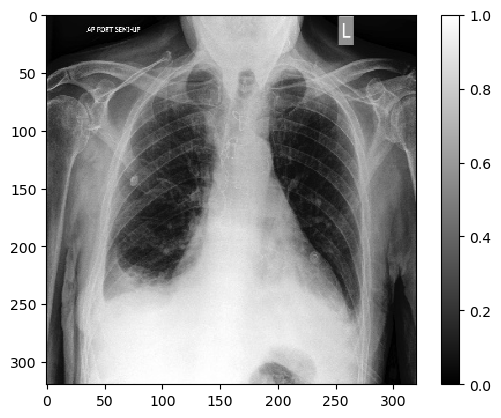

In [190]:
my_iter = iter(test_loader_max)
sample = next(my_iter)
im = plt.imshow(sample[0][0][0].numpy(), cmap='grey', interpolation='none')
plt.colorbar(im)

In [237]:
class APPAModel(pl.LightningModule):
    def __init__(self, name = "appa-model"):
        super().__init__()
        #self.model = torchvision.models.resnet50(pretrained= True)
        self.model = timm.create_model("resnetv2_50", pretrained=True, num_classes=2, in_chans=1)
        #self.model = timm.create_model('efficientnetv2_rw_s', pretrained=True, num_classes=3, in_chans=1)
        self.batch_size = BATCH_SIZE

        self.name = name
        
        self.save_hyperparameters()
        self.train_metrics = []
        self.val_metrics = []
        self.test_metrics = []
        
        #class_weights = np.array([2,1,3], dtype=float)
        #class_weights = class_weights*len(class_weights)/sum(class_weights)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        #self.loss_fn = torch.nn.CrossEntropyLoss()

        
        self.metric_accuracy = MulticlassAccuracy(num_classes=2, average=None).to(device)

        self.metric_precision = MulticlassPrecision(num_classes=2, average=None).to(device)

        self.metric_recall = MulticlassRecall(num_classes=2, average=None).to(device)

        self.metric_f1 = MulticlassF1Score(num_classes=2, average=None).to(device)

        self.metric_specificity = MulticlassSpecificity(num_classes=2, average=None).to(device)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        
        x, y = batch
        logits = self(x)

        logits = logits.float()
        y = y.float()

        loss = self.loss_fn(np.squeeze(logits, axis=1), y)

        self.update_metrics(preds=np.squeeze(logits, axis=1), targets=np.argmax(y.cpu(), axis=1).to(device))

        self.log('train_loss', loss)
        self.log_metrics('train')
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch

        logits = self(x)

        logits = logits.float()
        y = y.float()

        loss = self.loss_fn(np.squeeze(logits,axis=1), y.float())

        self.update_metrics(preds=np.squeeze(logits,axis=1), targets=np.argmax(y.cpu(), axis=1).to(device))

        if stage:
            self.log(f'{stage}_loss', loss)
            self.log_metrics(stage)

    def test_step_ignore(self, batch, batch_idx):
        x, y = batch

        logits = self(x).float()
        y = y.float()
        
        loss = self.loss_fn(np.squeeze(logits,axis=1), y.float())

        self.update_metrics(preds=np.squeeze(logits,axis=1), targets=y)

        self.test_accuracy
        self.test_precision
        self.test_recall
        self.test_f1
        self.test_specificity
        
        self.log_dict({'test_loss': loss, 'test_acc': self.test_accuracy,
                      "test_precision":self.test_precision, "test_recall":self.test_recall,
                       "test_f1":self.test_f1, "test_specificity":self.test_specificity})

    def on_test_start(self):
        self.reset_metrics()

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")
    
    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, stage='val')

    def on_validation_epoch_start(self):
        keys = ["AP","PA"]
        self.train_metrics.append({'Epoch': self.current_epoch,
                                    'Metrics':
                                        {'Accuracy': dict(zip(keys, self.accuracy.tolist())),
                                        'Precision': dict(zip(keys, self.precision.tolist())),
                                        'Recall': dict(zip(keys, self.recall.tolist())),
                                        'F1': dict(zip(keys, self.f1.tolist())),
                                        'Specificity': dict(zip(keys, self.specificity.tolist()))}})

        with open(f"config_files/train_metrics_{self.name}.json", 'w') as f:
            json.dump(self.train_metrics, f)

        self.metric_accuracy.reset()
        self.metric_precision.reset()
        self.metric_recall.reset()
        self.metric_f1.reset()
        self.metric_specificity.reset()

    def on_validation_epoch_end(self):
        keys = ["AP","PA"]
        self.val_metrics.append({'Epoch': self.current_epoch,
                                 'Metrics':
                                     {'Accuracy': dict(zip(keys,self.accuracy.tolist())),
                                      'Precision': dict(zip(keys,self.precision.tolist())),
                                      'Recall': dict(zip(keys,self.recall.tolist())),
                                      'F1': dict(zip(keys,self.f1.tolist())),
                                      'Specificity': dict(zip(keys,self.specificity.tolist()))}})

        with open(f"config_files/val_metrics_{self.name}.json", 'w') as f:
            json.dump(self.train_metrics, f)

        self.metric_accuracy.reset()
        self.metric_precision.reset()
        self.metric_recall.reset()
        self.metric_f1.reset()
        self.metric_specificity.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr= LEARNING_RATE,
            momentum=0.9,
            weight_decay=5e-4,
        )
        
        steps_per_epoch = 45000 // self.batch_size
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=self.trainer.limit_train_batches,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

    def reset_metrics(self):
        self.metric_accuracy.reset()
        self.metric_precision.reset()
        self.metric_recall.reset()
        self.metric_f1.reset()
        self.metric_specificity.reset()
    
    def update_metrics(self, preds, targets):
        self.metric_accuracy.update(preds, targets)
        self.metric_precision.update(preds, targets)
        self.metric_recall.update(preds, targets)
        self.metric_f1.update(preds, targets)
        self.metric_specificity.update(preds, targets)


    def log_metrics(self, stage=None):
        accuracy = self.metric_accuracy.compute()
        precision = self.metric_precision.compute()
        recall = self.metric_recall.compute()
        f1 = self.metric_f1.compute()
        specificity = self.metric_specificity.compute()

        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.f1 = f1
        self.specificity = specificity

        self.log(f'{stage}_accuracy_APPA', accuracy.mean())
        self.log(f'{stage}_precision_APPA', precision.mean())
        self.log(f'{stage}_recall_APPA', recall.mean())
        self.log(f'{stage}_f1_APPA', f1.mean())
        self.log(f'{stage}_specificity_APPA', specificity.mean())


In [238]:
appa_model_under = APPAModel(name="under")
appa_model_limit = APPAModel(name="limit")
appa_model_max = APPAModel(name="max")

In [239]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback_under = ModelCheckpoint(
     monitor='val_loss',
     dirpath="model-checkpointing",
     filename='appa_under-{epoch:02d}-{val_loss:.2f}'
)

checkpoint_callback_limit = ModelCheckpoint(
     monitor='val_loss',
     dirpath="model-checkpointing",
     filename='appa_limit-{epoch:02d}-{val_loss:.2f}'
)

checkpoint_callback_max = ModelCheckpoint(
     monitor='val_loss',
     dirpath="model-checkpointing",
     filename='appa_max-{epoch:02d}-{val_loss:.2f}'
)


In [248]:
import tensorboard
import tensorboardX
from pytorch_lightning.loggers import TensorBoardLogger

trainer_under = pl.Trainer(logger=TensorBoardLogger(save_dir="logs_under/"), 
                     max_epochs=NUM_EPOCHS, 
                     num_sanity_val_steps=0,
                     limit_train_batches=len(train_set_under)//BATCH_SIZE,
                     limit_val_batches=len(valid_set_under)//BATCH_SIZE,
                     callbacks=[checkpoint_callback_under]
                    )

trainer_limit = pl.Trainer(logger=TensorBoardLogger(save_dir="logs_limit/"), 
                     max_epochs=NUM_EPOCHS, 
                     num_sanity_val_steps=0,
                     limit_train_batches=len(train_set_limit)//BATCH_SIZE,
                     limit_val_batches=len(valid_set_limit)//BATCH_SIZE,
                     callbacks=[checkpoint_callback_limit]
                    )

trainer_max = pl.Trainer(logger=TensorBoardLogger(save_dir="logs_max/"), 
                     max_epochs=NUM_EPOCHS, 
                     num_sanity_val_steps=0,
                     limit_train_batches=len(train_set_max)//BATCH_SIZE,
                     limit_val_batches=len(valid_set_max)//BATCH_SIZE,
                     callbacks=[checkpoint_callback_max]
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [249]:
trainer_limit.fit(appa_model_limit, train_loader_limit, valid_loader_limit)
torch.save(appa_model_limit, "save/appa-limit.pt")

trainer_under.fit(appa_model_under, train_loader_under, valid_loader_under)
torch.save(appa_model_under,"save/appa-under.pt")

trainer_max.fit(appa_model_max, train_loader_max, valid_loader_max)
torch.save(appa_model_max, "save/appa-max.pt")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                  | Params | Mode 
---------------------------------------------------------------------
0 | model              | ResNetV2              | 23.5 M | train
1 | loss_fn            | CrossEntropyLoss      | 0      | train
2 | metric_accuracy    | MulticlassAccuracy    | 0      | train
3 | metric_precision   | MulticlassPrecision   | 0      | train
4 | metric_recall      | MulticlassRecall      | 0      | train
5 | metric_f1          | MulticlassF1Score     | 0      | train
6 | metric_specificity | MulticlassSpecificity | 0      | train
---------------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
93.993    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                  | Params | Mode 
---------------------------------------------------------------------
0 | model              | ResNetV2              | 23.5 M | train
1 | loss_fn            | CrossEntropyLoss      | 0      | train
2 | metric_accuracy    | MulticlassAccuracy    | 0      | train
3 | metric_precision   | MulticlassPrecision   | 0      | train
4 | metric_recall      | MulticlassRecall      | 0      | train
5 | metric_f1          | MulticlassF1Score     | 0      | train
6 | metric_specificity | MulticlassSpecificity | 0      | train
---------------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
93.993    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

KeyboardInterrupt: 

In [252]:
trainer_under.fit(appa_model_under, train_loader_under, valid_loader_under)
torch.save(appa_model_under,"save/appa-under.pt")


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                  | Params | Mode 
---------------------------------------------------------------------
0 | model              | ResNetV2              | 23.5 M | train
1 | loss_fn            | CrossEntropyLoss      | 0      | train
2 | metric_accuracy    | MulticlassAccuracy    | 0      | train
3 | metric_precision   | MulticlassPrecision   | 0      | train
4 | metric_recall      | MulticlassRecall      | 0      | train
5 | metric_f1          | MulticlassF1Score     | 0      | train
6 | metric_specificity | MulticlassSpecificity | 0      | train
---------------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
93.993    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

KeyboardInterrupt: 

In [242]:
test_model = APPAModel.load_from_checkpoint(checkpoint_callback_limit.best_model_path)

In [253]:
test_model = APPAModel.load_from_checkpoint("save/appa-limit.pt")

TypeError: 'APPAModel' object is not subscriptable

In [268]:
test_model = torch.load("save/appa-max.pt")

In [269]:
total_corr = 0
total_att = 0

AP_corr = 0
AP_att = 0

PA_corr = 0
PA_att = 0

In [270]:
len(test_loader_limit)

20000

In [271]:
counter = 0

for batch in test_loader_limit:
    if counter%1000 == 0:
        print("counter:",counter)

    counter += 1
    
    x,y = batch
    x = x.to(device)
    y = y.to(device)
    
    outputs = test_model(x)

    outputs = outputs.cpu().detach()
    y = y.cpu().detach()

    for ins in zip(outputs, y):
        pred, tar = ins

        if(np.argmax(pred) == np.argmax(tar)):
            if np.argmax(tar) == 0:
                AP_corr += 1
                AP_att += 1
            else:
                PA_corr += 1
                PA_att += 1
        else:
            if np.argmax(tar) == 0:
                AP_att += 1
            else:
                PA_att += 1

counter: 0
counter: 1000


Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7f24ebb10e00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):

KeyboardInterrupt: 


KeyboardInterrupt: 

In [272]:
print(AP_corr/AP_att)

0.9839653444541429


In [273]:
print(PA_corr/PA_att)

0.9422006821037515
